<h1><center> MODEL </center></h1>

 <center>
    <h1><center>Microsoft malware classification</center></h1>
    <i>Klasifikacija zlonamjernog softvera</i> 
    <br><br>
    PRIRODOSLOVNO MATEMATIČKI FAKULTET - MATEMATIČKI ODSJEK <br>
    <b>Lipanj 2020.</b> 
    <br><br>
    <i>Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita</i>  
</center>

***

[comment]: <> (Paketi koje je potrebno instalirati prije pokretanja bilježnice: <br>)
[comment]: <> (<code>conda install -c anaconda py-xgboost</code> <br>)
[comment]: <> (<code>conda install -c conda-forge imbalanced-learn</code>)

In [75]:
# packages
import numpy as np
from numpy import mean
from numpy import std
from numpy import loadtxt
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.core.pylabtools import figsize
from collections import Counter
import random

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import precision_score, log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from functions.model_helper import *
from functions.fs_helper import *
from functions.build_model_helper import *

from yellowbrick.classifier import ClassBalance, ROCAUC
from yellowbrick.classifier import ClassificationReport, ClassPredictionError

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
# remember default python style
IPython_default = plt.rcParams.copy()

# dictionary for saving malware names
malware_dict = { 1 : 'Ramnit', 2 : 'Lollipop', 3 : 'Kelihos_ver3', 4 : 'Vundo', 5 : 'Simba', 
                 6 : 'Tracur', 7 : 'Kelihos_ver1', 8 : 'Obfuscator.ACY', 9 : 'Gatak'}

# define seed
seed = 42

<br><br>


#### UČITAVANJE PODATAKA

In [4]:
# loading all features in train set
features_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_all_features.csv")

# loading all features in train set
features_test1 = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/test_features_first_10000.csv")
features_test2 = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/test_features_last_873.csv")
features_test = features_test1.append(features_test2)

# malware ids
md5hash_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/md5hash_train.csv")
md5hash_test = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/md5hash_test.csv")

# load train data malware classes
malware_classes_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/malware_classes_train.csv")

# features with filled NaN with zero
features_train_with_filled_NaN_without_id = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/features_train_with_filled_NaN_without_id.csv")
features_test_with_filled_NaN_without_id = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/features_test_with_filled_NaN_without_id.csv")

In [5]:
md5hash_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/md5hash_train.csv")
features_train_with_filled_NaN_without_id = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/features_train_with_filled_NaN_without_id.csv")

md5hash_test = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/md5hash_test.csv")
features_test_with_filled_NaN_without_id = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/features_test_with_filled_NaN_without_id.csv")


##### odabrane značajke

In [6]:
# load features from train and test dataset given using rfecv
selected_features_train = pd.read_csv("https://raw.githubusercontent.com/tomarga/Machine-Burning/master/dataset/selected%20features/ROC_AUC/samo%20rfecv/features_train_SAMORFECV_rfecv_rf_OVO_cv5_nestim200.csv")
selected_features_test = pd.read_csv("https://raw.githubusercontent.com/tomarga/Machine-Burning/master/dataset/selected%20features/ROC_AUC/samo%20rfecv/features_test_SAMORFECV_rfecv_rf_OVO_cv5_nestim200.csv")

# load table with feature names and their scores, sorted
feature_importances = pd.read_csv("https://raw.githubusercontent.com/tomarga/Machine-Burning/master/dataset/selected%20features/ROC_AUC/samo%20rfecv/SAMORFECV_rfecv_rf_OVO_cv5_nestim200_feature_selected_with_names_and_importance_scores_sorted.csv")

# define number of features to use (explained in 'feature_selection_final.ipynb')
number_of_features_to_use = 208

In [7]:
feature_importances.head()

,feature_name,feature_importance
0,ent_q_diff_diffs_1_min,0.019235
1,ent_q_diff_diffs_2_median,0.018185
2,ent_q_diff_diffs_2_min,0.015941
3,byte_1G_a2,0.015251
4,byte_1G_a7,0.015016


In [8]:
# define data
data = selected_features_train[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]
data_test = selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]
labels = malware_classes_train.values.ravel()

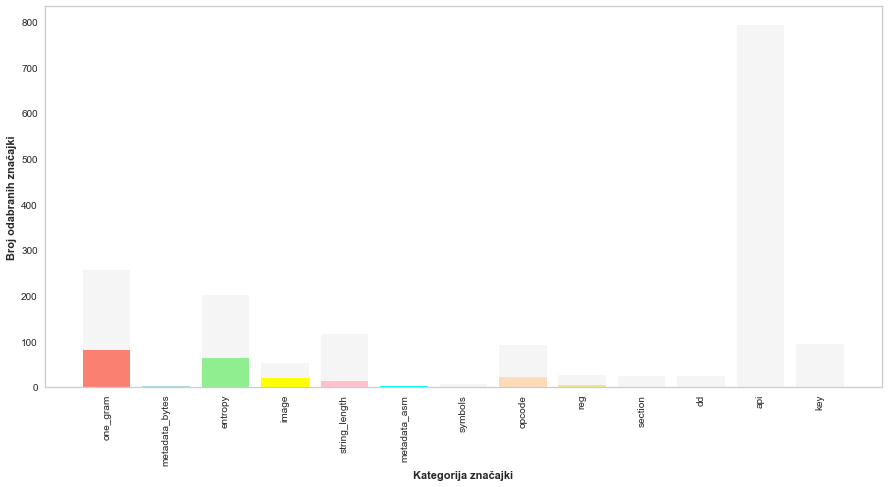

In [9]:
features_type_quantity(list(feature_importances["feature_name"].values[:number_of_features_to_use]), features_train)

Na prethodnoj slici možemo vidjeti raspodijelu odabranih značajki po grupama.

In [10]:
# split data
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

<br><br>


# Model

Sada će prikazati uspješnost našega najboljeg modela kojeg smo prethodno spremili.

In [11]:
#load model
filename = 'best_model.sav'
model = pickle.load(open(filename, 'rb'))

In [12]:
model_results = model_results(model, X_test, y_test)
model_results

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.012894
1,accuracy_test,0.995860
2,F1_test,0.995860
3,precision_test,0.995861
4,auc_test_ovr,0.999985
5,auc_test_ovo,0.999984
6,r2_test,0.981486


Ovdje smo ispisali različite metrike uspješnosti našega jednostavnog modela. Ono što možemo primjetiti da su rezultati svih metrika vrlo dobri te očekujemo slične i na <i>Kaggle</i> podacima za koje nam nije poznata klasa u koju pripadaju.

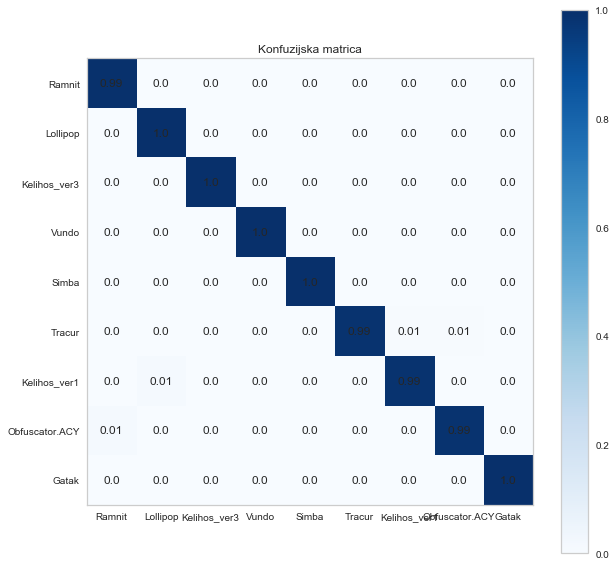

In [13]:
#plt.style.use(plt.style.available[10])
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

Iz konfuzijske matrice vidimo da naš model odlično grupira podatke u klase u koje pripadaju.

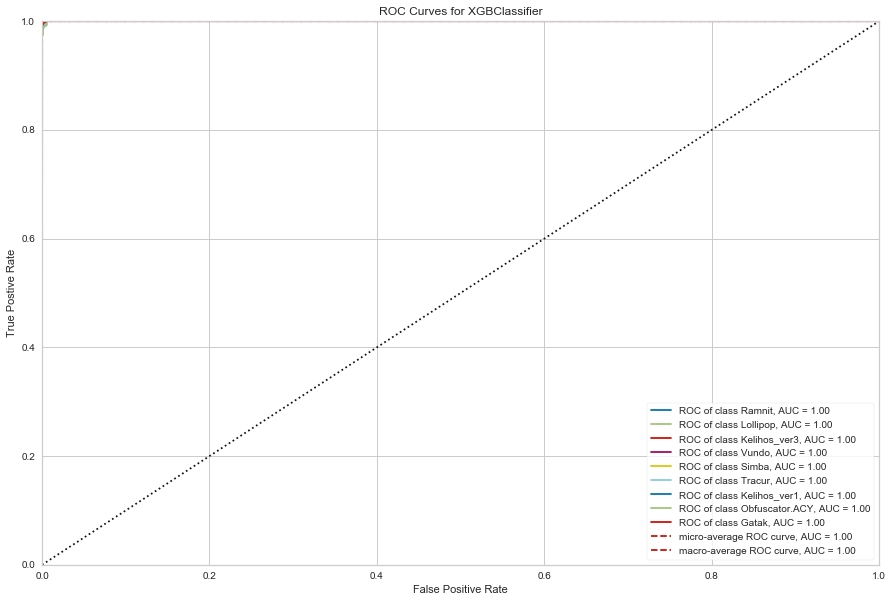

In [14]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#plt.style.use(plt.style.available[20])
#plt.rcParams.update(IPython_default)

rocauc = ROCAUC(model, size=(1080, 720), classes=list(malware_dict.values()), encoder=malware_dict )

rocauc.score(X_test, y_test)    
r = rocauc.poof()

Na gornjoj slici možemo vidjeti uspješnost modela prikazanu preko <i>ROC</i> krivulje. Za sve klase, površina ispod te krivulje (<i>AUC</i>) je maksimalna, odnosno iznosi $1$, što je još jedan pokzatelj dobroga modela.

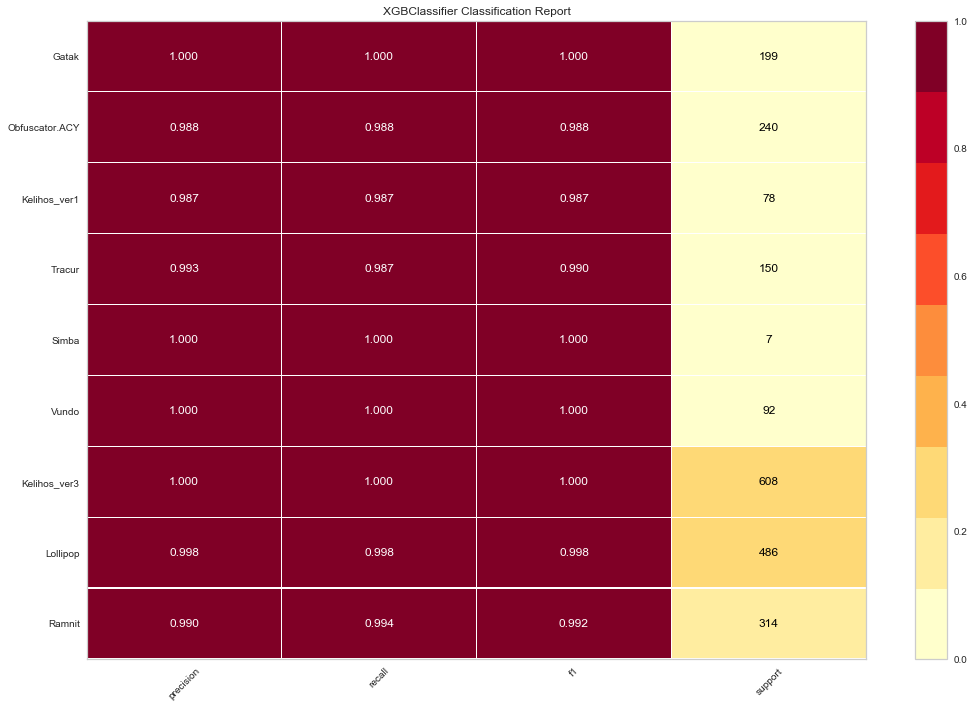

In [15]:
report = ClassificationReport(model, size=(1080, 720), support=True, force_model=True, classes=list(malware_dict.values()), encoder=malware_dict)

report.score(X_test, y_test)
c = report.poof()

Iz prethodne tablice možemo vidjeti rezultate za <i>precision</i>, <i>recall</i> i <i>f1</i> mjere točnosti modela za svaku od klasa <i>malware</i>-a.

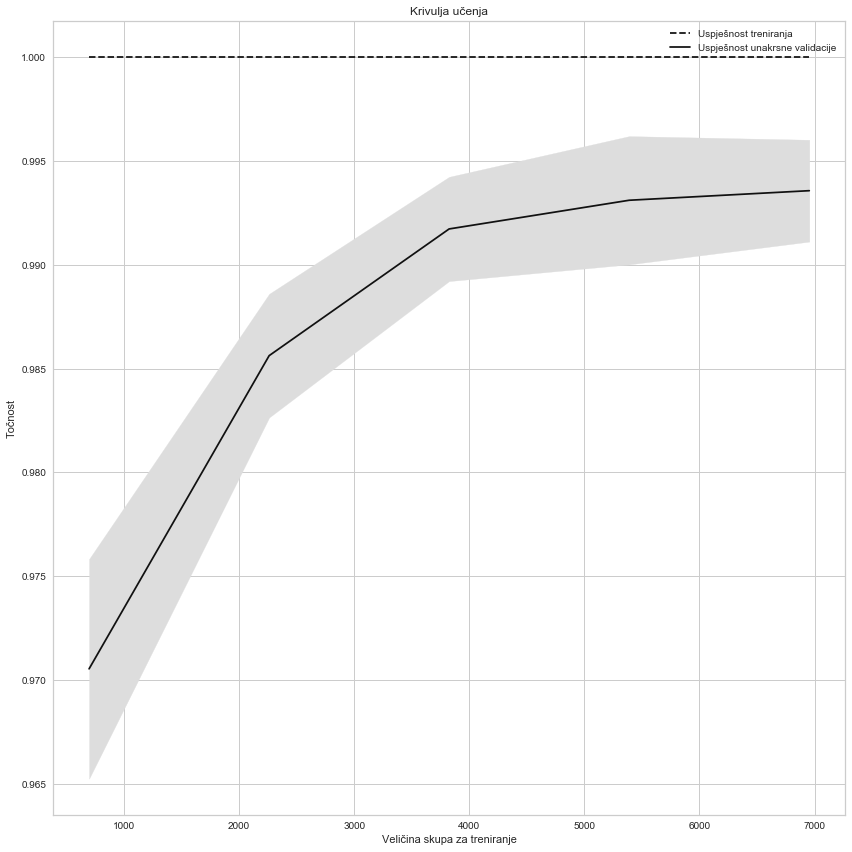

Accuracy: 99.59%


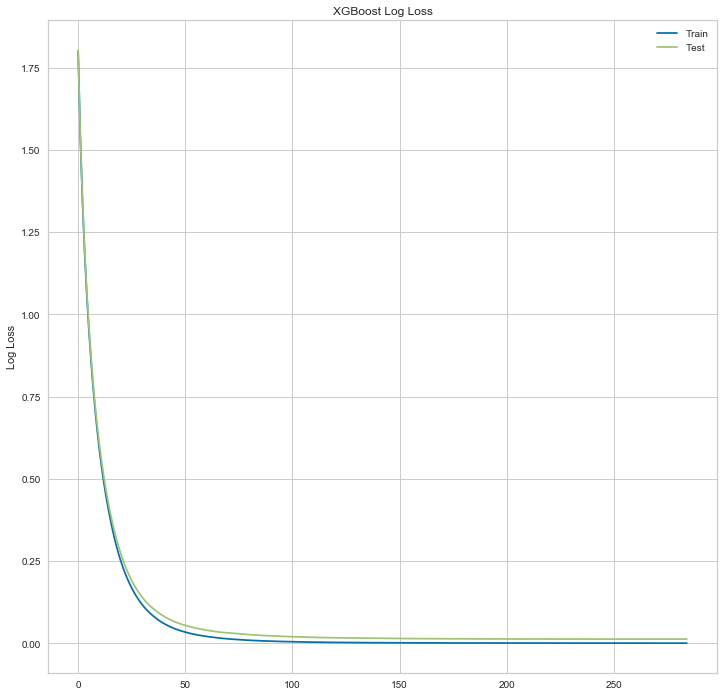

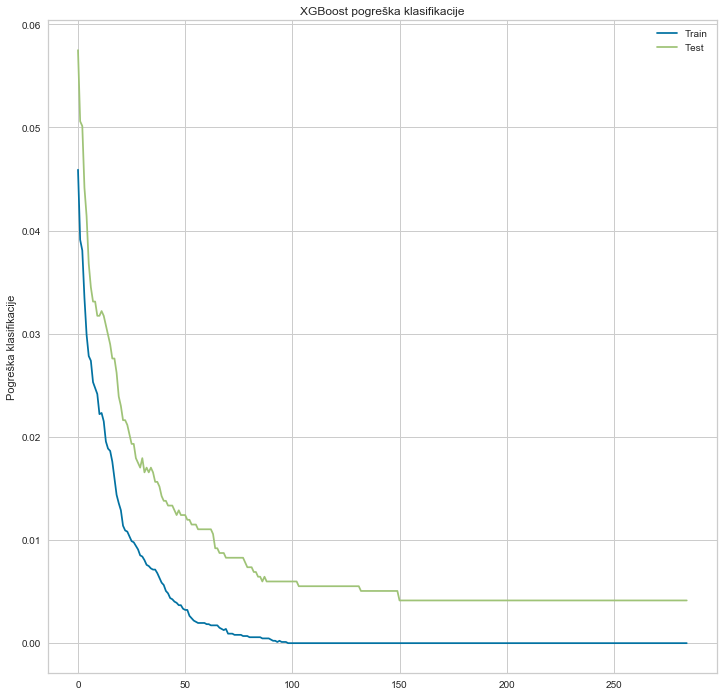

In [16]:
plot_learning_curve( model, X_train, y_train, X_test, y_test, 5, seed)

Na gornjoj slici vidimo krivulju učenja za $5$-erostruku unakrsnu validaciju.

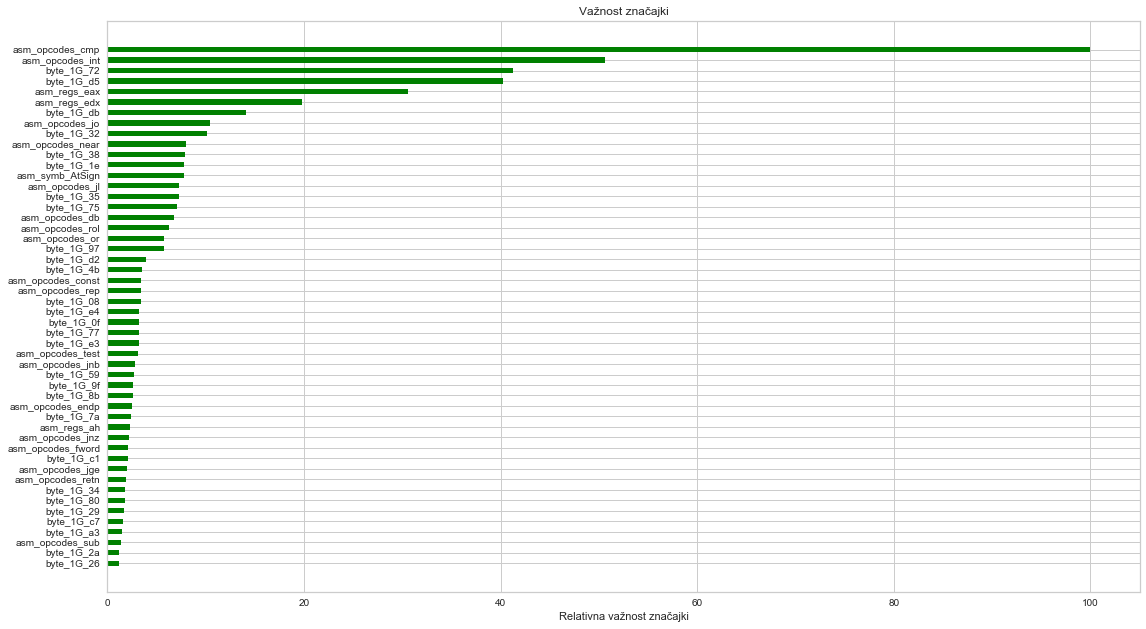

In [73]:
plot_feature_importance2(model, number_of_features_to_use, feature_importances)

Na prethodnoj slici prikazane su najvažnije značajke u modelu.

Broj malwarea po klasama:
dict_values([1546, 2480, 2946, 478, 42, 754, 400, 1218, 1009])
Postotci malware-aa po klasama:
[14.218706888623196, 22.808792421594777, 27.094638094362182, 4.396210797388026, 0.3862779361721696, 6.934608663662282, 3.678837487353996, 11.202060148992917, 9.279867561850455]


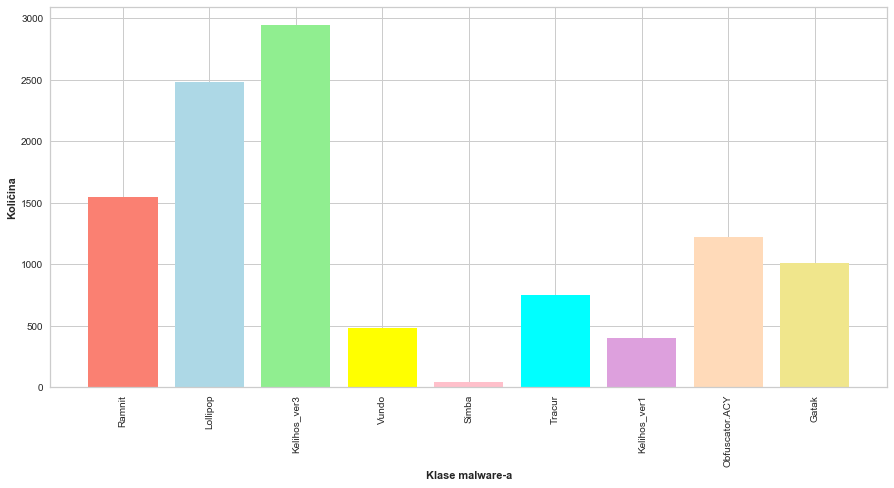

In [18]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))
draw_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

Prije <i>submit</i>-anja, mogli bismo nešto reći o našim rezultatima na $10873$ <i>malware</i>-a za koje nam nije poznata klasa iz prethodno nacrtanog grafa. Naime, on pokazuje raspodjelu tih podataka po klasama. Ako se prisjetimo kako je izgledao isti graf na podacima za koje nam je bila poznata klasa <i>malware</i>-a u koju pripadaju ([Projektni prijedlog](https://github.com/tomarga/Machine-Burning/blob/master/src/%5Bproject%20proposal%5D%20microsoft%20malware%20classification.ipynb)), mogli bismo, samo iz ta dva grafa, reći da smo dobro grupirali podatke jer je distribuiranost po klasama vrlo slična i u jednom i u drugom grafu.

<br><br>

Kako bi što bolje grafički objasnili podatke, nacrtali smo i reprezentaciju podataka u $3D$-u smanjivanjem dimenzionalnosti korištenih značajki na $3$ dimenzije. Različitim bojama, na prvoj slici, prikazali smo klasifikaciju podataka za koje nam je poznata klasa u koju pripadaju. Na drugoj slici učinili smo isto za podatke za <i>Kaggle</i> podatke za testiranje na temelju klasa koje je naš model predvidio za te podatke.

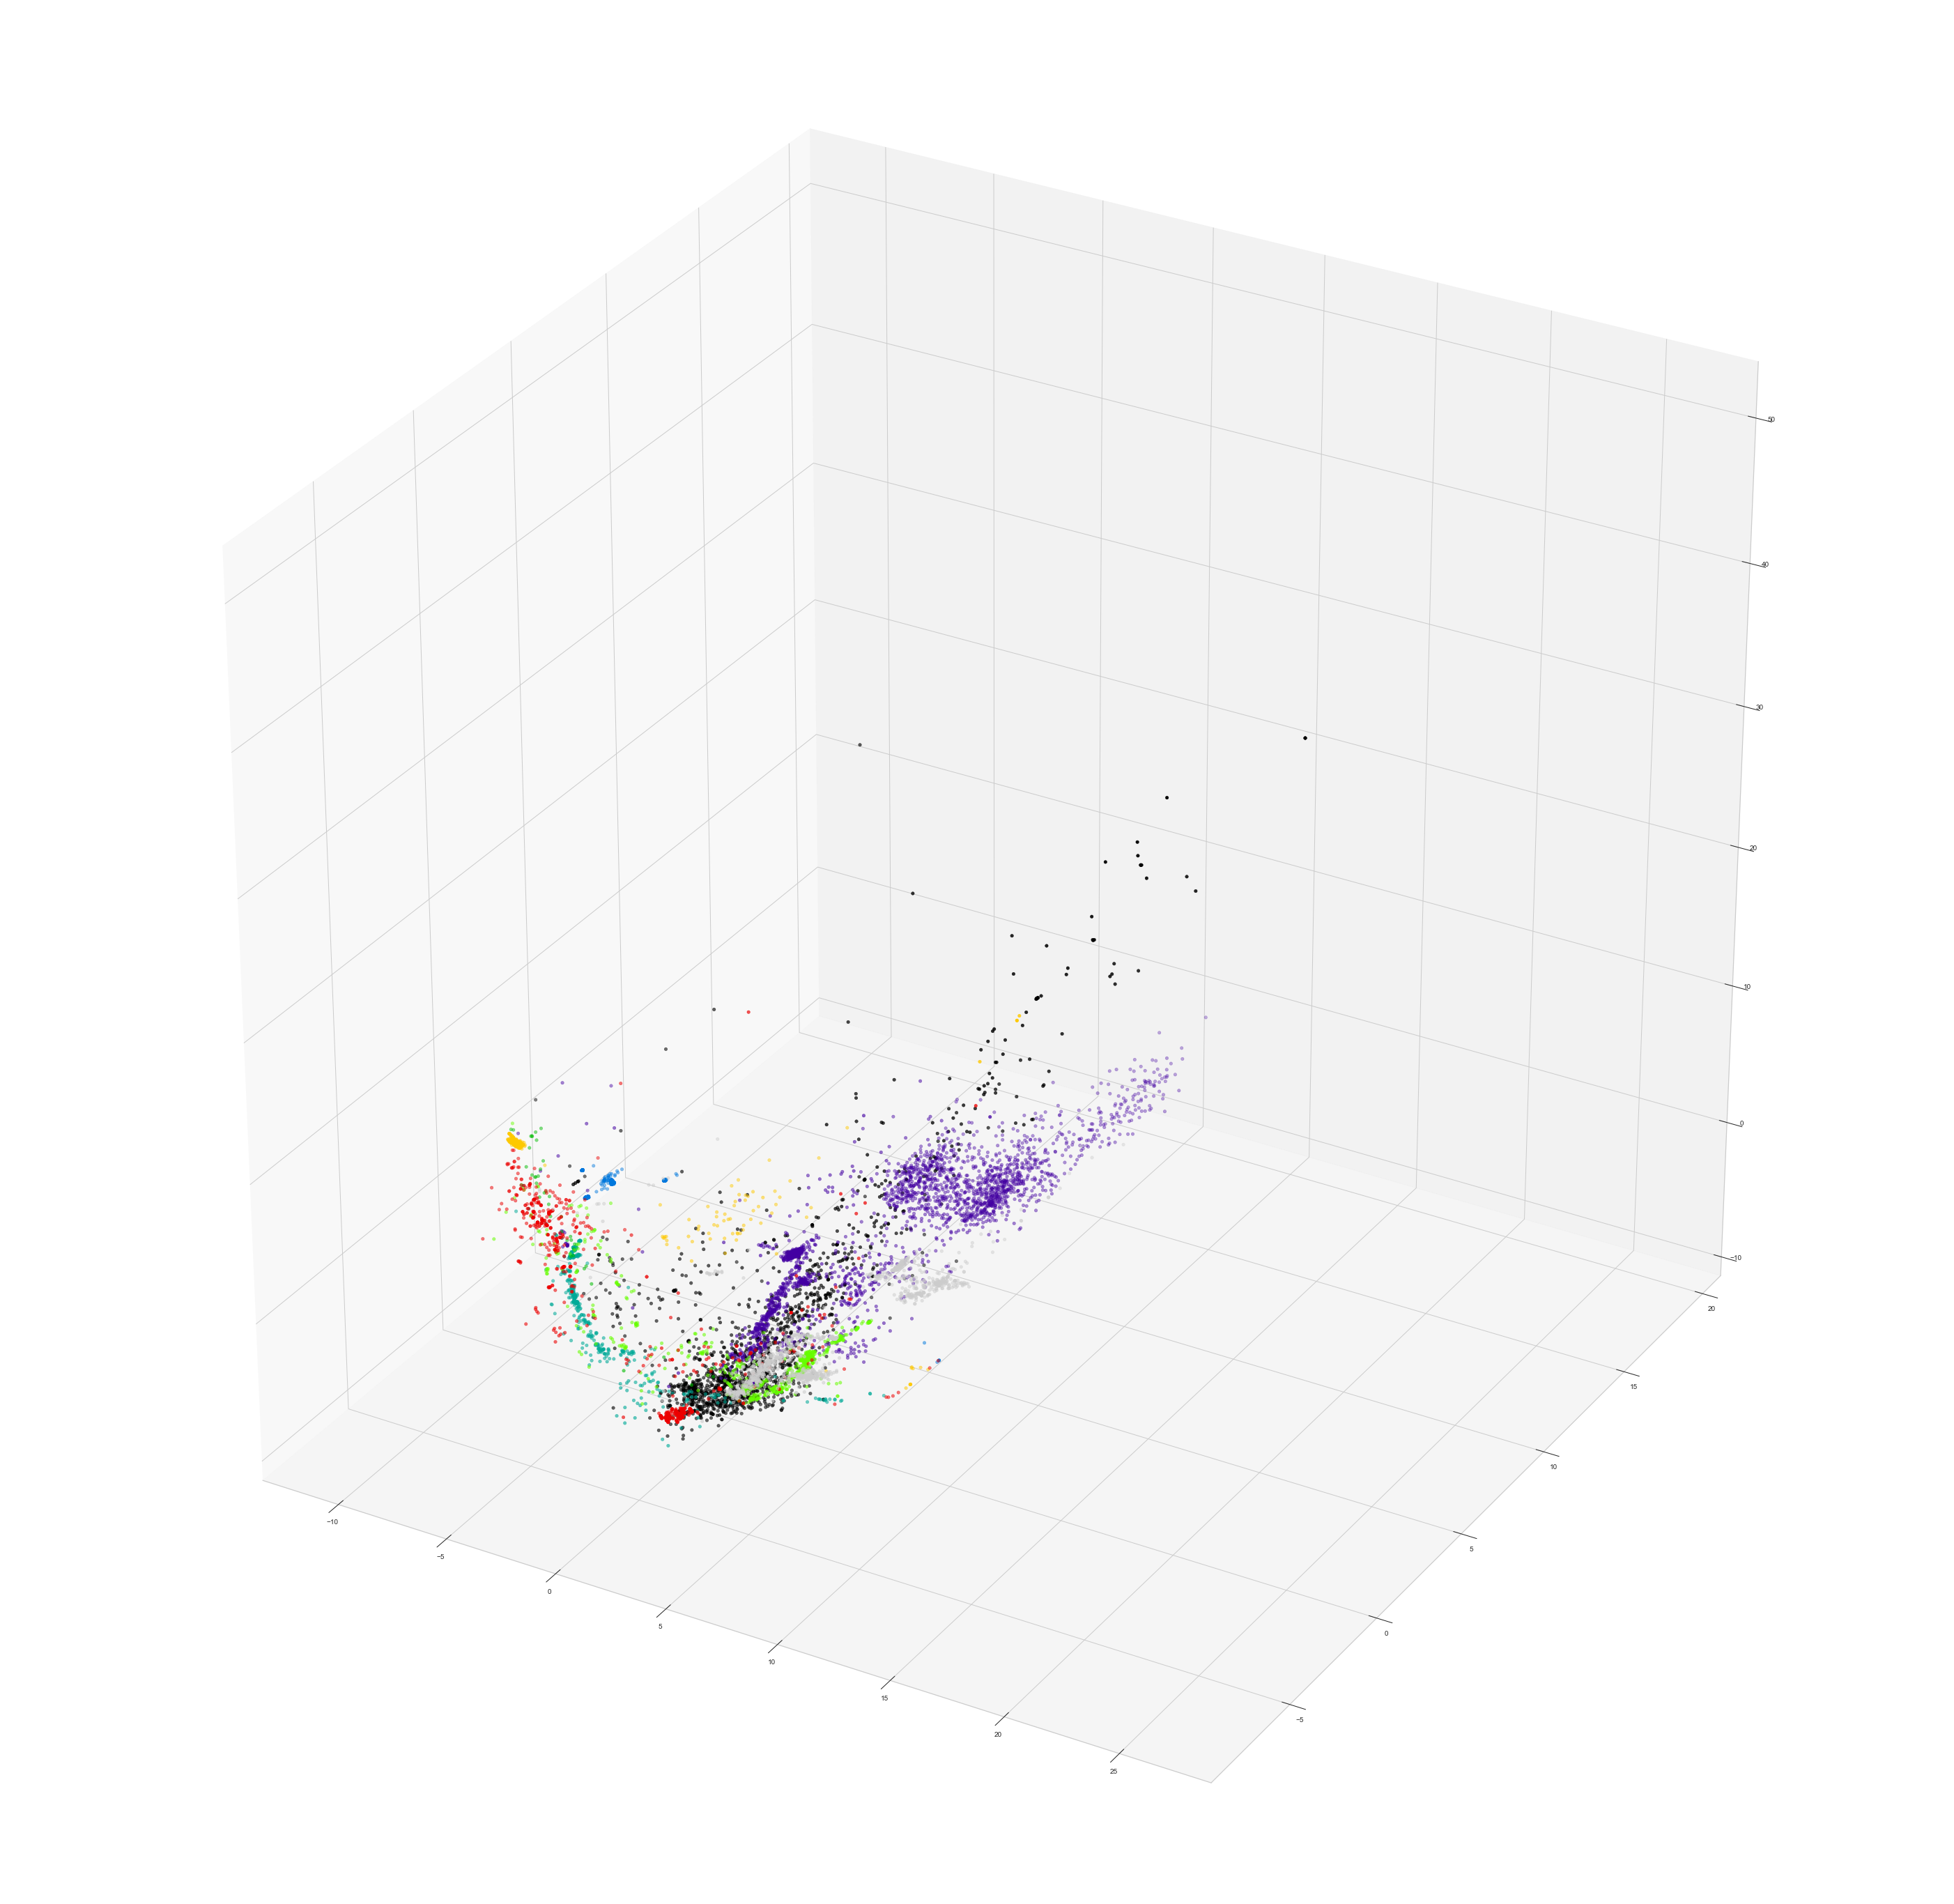

In [76]:
# draw classification of train in 3d 
# pca
pca_plot(data, labels)

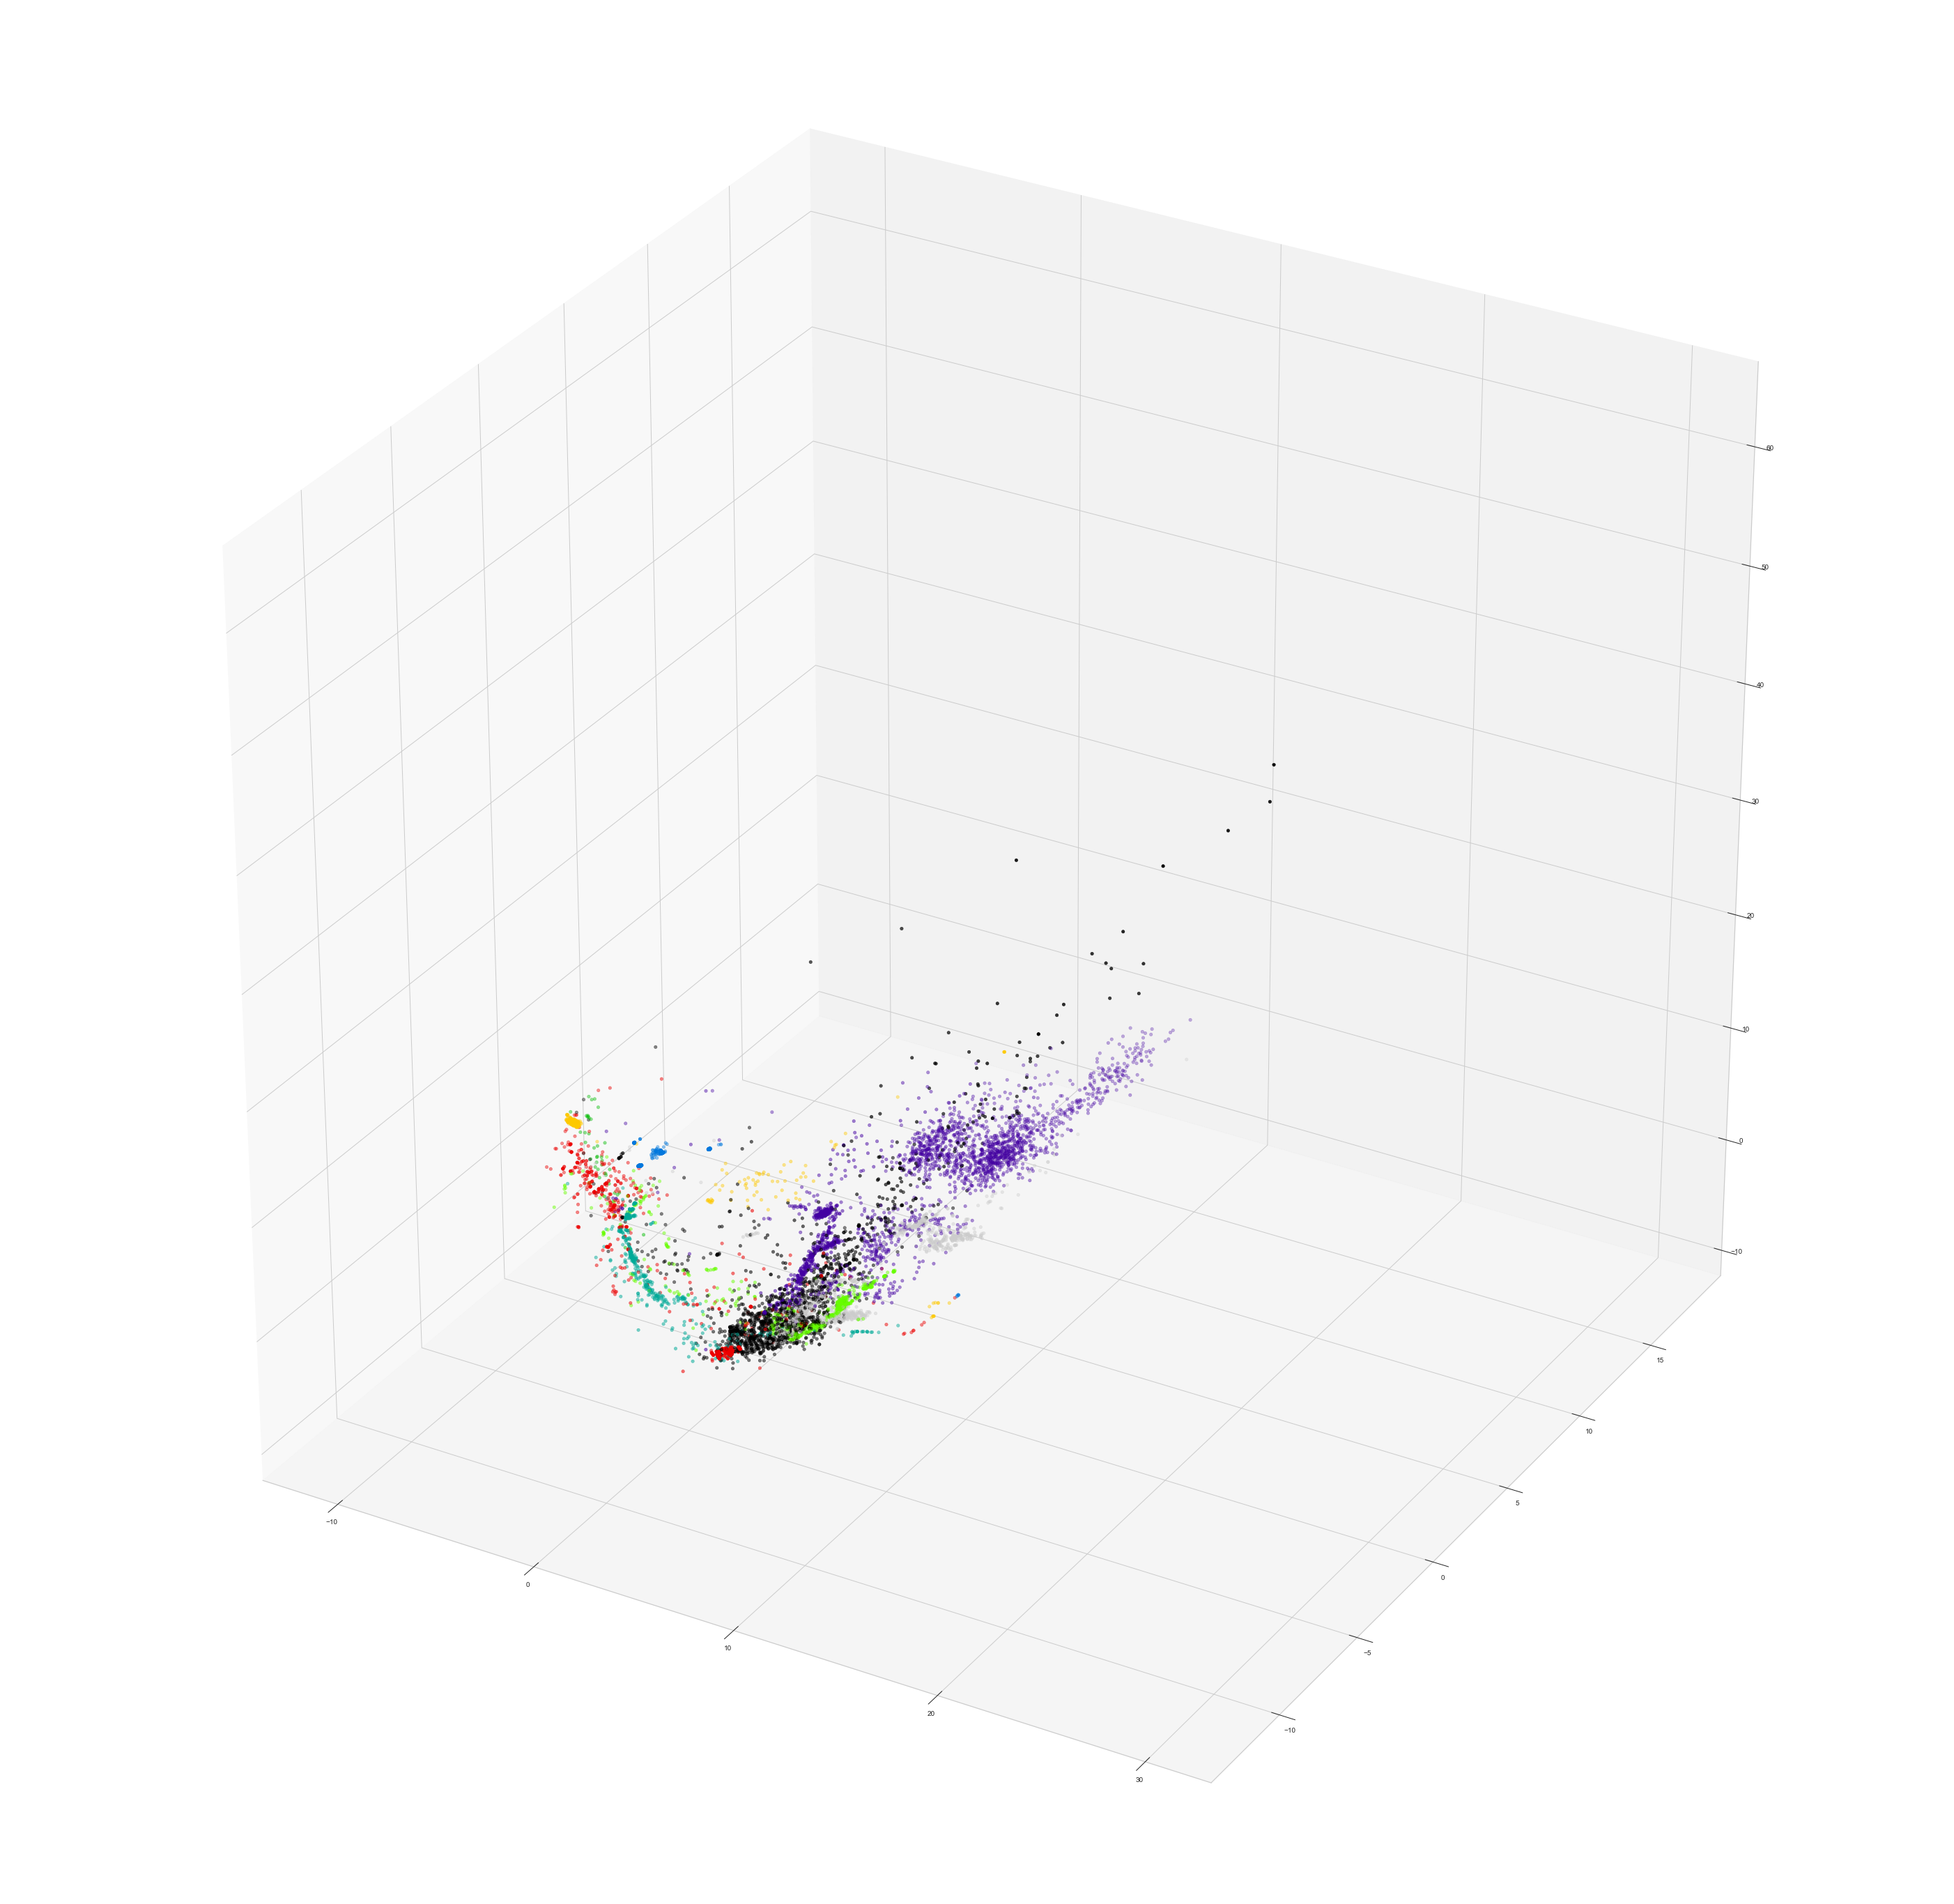

In [77]:
pca_plot(data_test, predicted_classes_on_kaggle_testset)

Vidimo da su klasifikacije vrlo slične, na temelju čega i vizualno možemo pretpostaviti dobru uspješnost našega modela.

<br><br><br>


***


# Submission

Sada ćemo kreirati datoteku s kojom ćemo provjeriti ( _logloss_ ) točnost _test_ skupa na [Kaggle-u](https://www.kaggle.com/c/malware-classification/overview).

In [ ]:
# make a submisson file
submission = make_submisson_file(md5hash_test, model.predict_proba(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))

In [ ]:
submission.head()

<code> Kaggle score: 0.01281 </code>

<br>

***

<br>

# Postupak izrade modela XGBoost-om

#### XGBoost PARAMETER TUNING

In [ ]:
# data
data = selected_features_train[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]
labels = malware_classes_train.values.ravel()

X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

In [ ]:
# get XGBClassifier parameters names
XGBClassifier().get_params().keys()

Definiranje svih parametara koje će pretraživati. 

In [ ]:
# define the parameter values that should be searched
n_estimators_range = [int(x) for x in np.linspace(start=70, stop=1000, num=10)]

# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# method of selecting samples for training each tree
bootstrap = [True, False]

# dictionary of parameters
random_grid = {
               'n_estimators': n_estimators_range,
               'max_features': ['auto','log2'],
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }

In [ ]:
# we use the RandomizedSearchCV to find the best parameters for our XGB model
[rand_XGB_model, rand_XGB_results_df] = RandomizedSearchCV_load_or_make(data=data, labels=labels, random_grid=random_grid, cv=5, scoring="neg_log_loss", n_iter=20, random_state=seed)

In [ ]:
rand_XGB_results_df

Ispsujemo tri najbolja skupa parametara dobivenih <i>RandomizedSearchCV</i>-om.

In [ ]:
from functions.model_helper import *

# examine the best n models
n = 3
best_n_models_params = report(rand_XGB_results_df, n_top=3)


<br> 

### GridSearch

GridSearch pomnije i detaljnije pretražuje prostor parametara. Stavljam mu da pretraži prostor oko već dobivenih najboljih parametara sa <i>RandomizedSearchCV</i>-om. 

In [ ]:
param_grid = {    'reg_lambda': [],
                  'reg_alpha': [],
                  'n_estimators': [],
                  'min_samples_split': [],
                  'min_samples_leaf': [],
                  'max_features': [],
                  'max_depth': [],
                  'learning_rate': [],
                  'gamma': [],
                  'bootstrap': []
              }

best_params = report(rand_XGB_results_df, n_top=1)

# adding parameters to be examined with GridSearch in params_grid
for key in param_grid.keys():
    for i in range(len(best_n_models_params)):
        if best_n_models_params[i][key] not in param_grid[key]:
            param_grid[key].append(best_n_models_params[i][key])
            
param_grid

In [ ]:
[grid_search, grid_search_results_df] = GridSearchCV_load_or_make(param_grid=param_grid, data=data, labels=labels, cv=5)

In [ ]:
grid_search_results_df

In [ ]:
from functions.model_helper import *

# examine the best n models
n = 3
best_n_models_params = report(grid_search.cv_results_, n_top=3)

In [ ]:
[param_tuning_xgb, param_tuning_xgb_results_df] = XGBClassifier_with_params(grid_search, X_train, y_train, X_test, y_test, early_stopping_rounds=20, eval_metric=["merror", "mlogloss"])

In [ ]:
model = param_tuning_xgb

<br><br>

<br>

## Nebalansiranost podatka

<br>

Kako su podaci nebalansirani s obzirom na distribuiranost po klasama, pokušali smo poboljšati model dodatnim uzorkovanjem metodom <code> Smote </code>.

In [89]:
best_params = {'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 586, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'bootstrap': True}

In [90]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

X_train, y_train = SMOTE(sampling_strategy='minority',k_neighbors=10).fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

xgb_classifier_smote = xgb.XGBClassifier(n_jobs=-1, verbose=True)
xgb_classifier_smote.set_params(**best_params)

xgb_classifier_smote.fit(X_train, y_train)

[(1, 1227), (2, 1991), (3, 2334), (4, 383), (5, 2334), (6, 601), (7, 320), (8, 988), (9, 814)]


XGBClassifier(base_score=0.5, booster='gbtree', bootstrap=True,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              max_features='auto', min_child_weight=1, min_samples_leaf=2,
              min_samples_split=5, missing=None, n_estimators=586, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbose=True, verbosity=1)

In [92]:
model = xgb_classifier_smote

In [93]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.013156
1,accuracy_test,0.996320
2,F1_test,0.996333
3,precision_test,0.996375
4,auc_test_ovr,0.999982
5,auc_test_ovo,0.999977
6,r2_test,0.986776


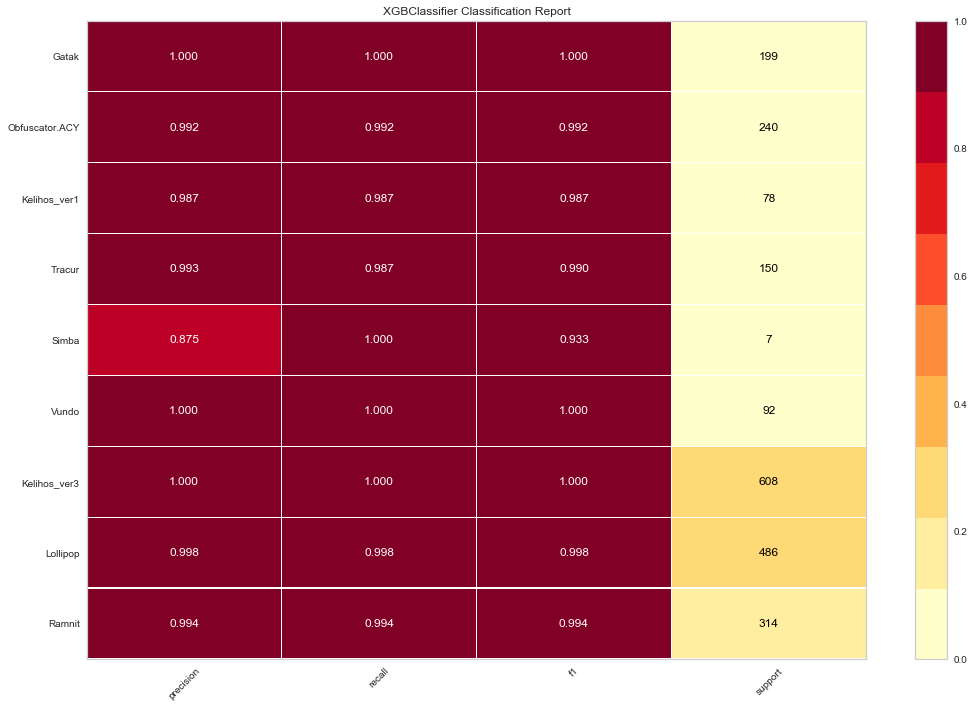

In [95]:
report = ClassificationReport(model, size=(1080, 720), support=True, force_model=True, classes=list(malware_dict.values()), encoder=malware_dict)

report.score(X_test, y_test)
c = report.poof()

Vidimo da dodatno uzorkovanje klase <i>Simba</i> rezultira lošiji <i>precision</i> nego model dobiven na orginalnim podacima stoga smo se ipak odlučili ne koristiti ovu metodu.

Broj malwarea po klasama:
dict_values([1547, 2480, 2945, 479, 46, 752, 400, 1216, 1008])
Postotci malware-aa po klasama:
[14.22790398234158, 22.808792421594777, 27.085441000643794, 4.40540789110641, 0.4230663110457096, 6.916214476225512, 3.678837487353996, 11.183665961556148, 9.27067046813207]


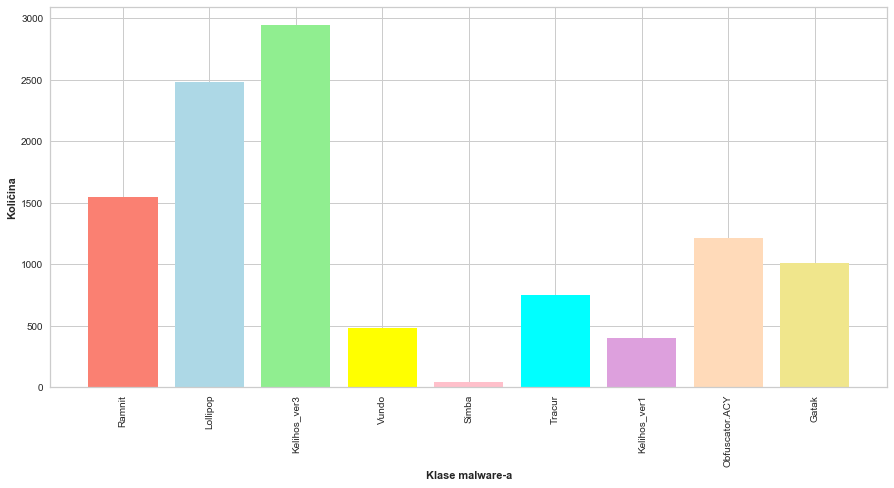

In [96]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(data_test))
draw_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)


I po povratnoj informaciji sa <i>Kaggle</i>-a, također možemo vidjeti da sa ovom metodom nismo uspjeli poboljšali uspješnost 
modela.

<code> Kaggle score: 0.01360</code>



<br><br><br><br>

***
<center><i>Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita</i> </center>